<a href="https://colab.research.google.com/github/masha-nv/llm/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [3]:
!pip install ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.3 MB/s eta 0:00:00


In [51]:
#|export
import gradio as gr
from fastdownload import download_url
from ddgs import DDGS


In [52]:
#|export
def get_images(keywords, max_images):
  return L(DDGS().images(keywords, max_images=max_images)).itemgot('image')

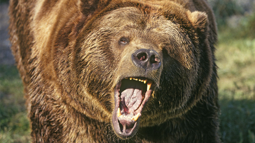

In [8]:
bear_url = get_images('bear', 1)[0]
dest = 'bear.jpg'
download_url(url=bear_url, dest=dest)
img = Image.open(dest)
img.to_thumb(255, 255)

In [9]:
searches = 'grizzly', 'panda', 'black bear'
for o in searches:
  path = Path('bears')
  path.mkdir(exist_ok=True, parents=True)
  dest = path/o
  urls = get_images(keywords=o, max_images=50)
  download_images(dest=dest, urls=urls)

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


18

In [11]:
dls = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    get_items=get_image_files,
    item_tfms=[RandomResizedCrop(128, min_scale=0.3)]
).dataloaders(path, bs=5)

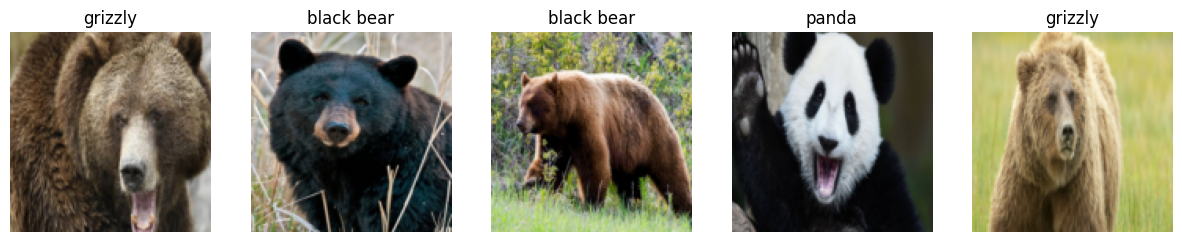

In [12]:
dls.valid.show_batch(max_n=6, nrows=1)

In [13]:
learn = vision_learner(dls=dls, arch=resnet18, metrics=accuracy)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.357267,0.302588,0.916667,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.498124,0.327252,0.895833,00:09
1,0.539351,0.481218,0.895833,00:10
2,0.498583,0.489702,0.916667,00:09


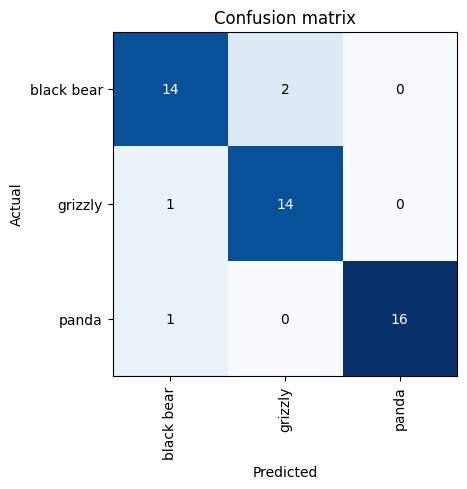

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

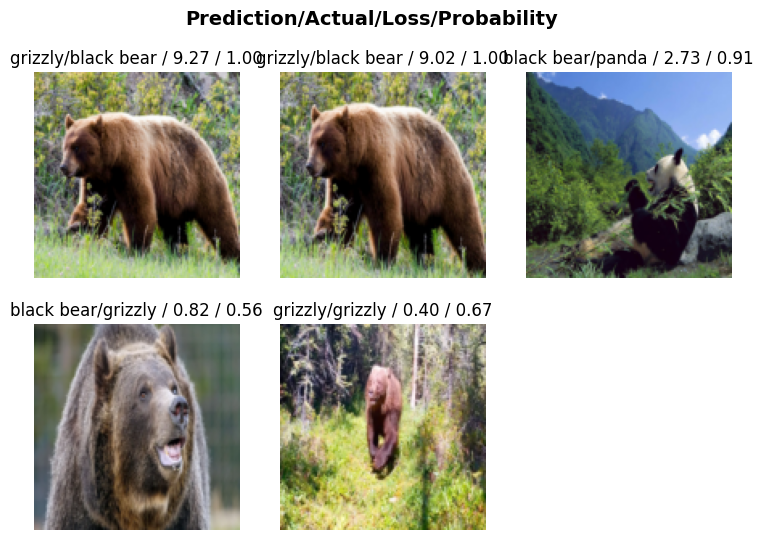

In [15]:
interp.plot_top_losses(5)

In [16]:
preds = learn.predict('bear.jpg')

In [17]:
learn.export()

In [18]:
l = load_learner('export.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [19]:
l.predict('bear.jpg')

('grizzly', tensor(1), tensor([1.9311e-03, 9.9806e-01, 4.3678e-06]))

In [20]:
learn.dls.vocab

['black bear', 'grizzly', 'panda']

In [53]:
#|export
def classify_image(img_url):
  pred, idx, probs = learn.predict(img_url)
  return dict(zip(learn.dls.vocab, map(float, probs)))

In [22]:
classify_image('bear.jpg')

{'black bear': 0.0019310711650177836,
 'grizzly': 0.9980645775794983,
 'panda': 4.367759629531065e-06}

In [55]:
#|export
interface = gr.Interface(classify_image, gr.Image(), gr.Label())
interface.launch(inline=False, debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e1b5a5e8fb7a5f0cf6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e1b5a5e8fb7a5f0cf6.gradio.live


In [61]:
from nbdev.export import nb_export

In [85]:
nb_export('/content/drive/My Drive/Colab Notebooks/app.ipynb', lib_path='/content/drive/My Drive/Colab Notebooks/app.ipynb')